<a href="https://colab.research.google.com/github/Harinadnan-shukla/Find_area_of_object_in_image/blob/main/Area_of_object_in_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is code written by Harinandan H , for any query write to me harinandan.h.shukla@gmail.com

In [ ]:
# First, install the required libraries (if not already installed)
!pip install torch torchvision

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
import torchvision.transforms as T


In [ ]:
# Provide the path to your image
image_path = '/cat and man.jpg'


In [ ]:

# Load the pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model_url = "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth"
model.load_state_dict(torch.hub.load_state_dict_from_url(model_url, progress=True, map_location=torch.device("cpu")))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [ ]:
# Define the COCO dataset labels
COCO_CLASS_NAMES = ['background','person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                   'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench',
                   'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat',
                   'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee',
                   'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                   'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife',
                   'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
                   'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table',
                   'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                   'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
                   'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


In [ ]:
# Define the image transformation
transform = T.Compose([T.ToTensor()])


In [ ]:

# Function to process the image and calculate the area
def process_image(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)

    # Put the input image into a batch
    batch = torch.unsqueeze(image_tensor, 0)

    # Run the image through the model
    with torch.no_grad():
        prediction = model(batch)

    # Extract the masks and boxes from the prediction
    masks = prediction[0]['masks']
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Ensure labels and boxes are in CPU and numpy format
    labels = labels.cpu().numpy().astype(int)
    boxes = boxes.cpu().numpy()

    # Calculate the area of the object(s) with confidence above the threshold
    areas = []
    for i in range(masks.shape[0]):
        if scores[i] > confidence_threshold:
            # Convert the mask to a binary numpy array
            mask = masks[i, 0].cpu().numpy()
            binary_mask = (mask > 0.5).astype(np.uint8)

            # Calculate the area of the object in pixels
            area_pixels = np.sum(binary_mask)

            label_index = labels[i]
            if label_index >= len(COCO_CLASS_NAMES) or label_index < 0:
                label_name = "Unknown"
            else:
                label_name = COCO_CLASS_NAMES[label_index]

            # Get bounding box coordinates (x1, y1, x2, y2)
            bbox = boxes[i]

            areas.append({"label": label_name, "area_pixels": area_pixels, "bbox": bbox})  # Save the area and label of the detected object

    return areas, image

In [ ]:
# Function to plot the image with bounding boxes and labels
def plot_image_with_bboxes(image, detected_objects):
    # Convert the image from PIL Image to numpy array for drawing the bounding boxes
    image_np = np.array(image.copy())

    # Create a draw object to draw on the image
    draw = ImageDraw.Draw(image)

    for detected_object in detected_objects:
        label_name = detected_object["label"]
        area_pixels = detected_object["area_pixels"]

        # Draw bounding box on the image
        x1, y1, x2, y2 = detected_object["bbox"]
        draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=2)

        # Draw label and area on the image
        label_text = f'{label_name} ({area_pixels} pixels)'
        draw.text((x1, y1 - 20), label_text, fill=(255, 0, 0), font=None)

    # Display the image with bounding boxes
    image.show()

Image Size (width x height): 120275
Area of person: 46657 pixels
Area of cat: 16175 pixels


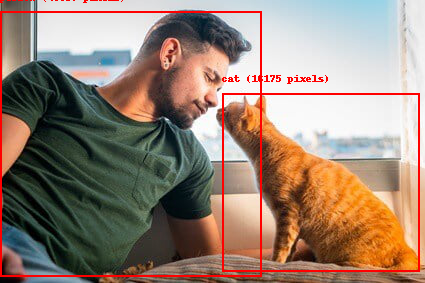

In [ ]:
# Load the image and process it
detected_objects, original_image = process_image(image_path)

# Print the size of the input image
width, height = original_image.size
print("Image Size (width x height):", width * height)

# Print the area and label of the detected objects
for detected_object in detected_objects:
    label_name = detected_object["label"]
    area_pixels = detected_object["area_pixels"]
    print(f"Area of {label_name}: {area_pixels} pixels")

# If no objects are detected, print a message
if not detected_objects:
    print("No objects detected.")
    # Plot the image with bounding boxes and labels
plot_image_with_bboxes(original_image, detected_objects)




#note:  i am not finding the area of bounding box



**This is code  for segmentation**

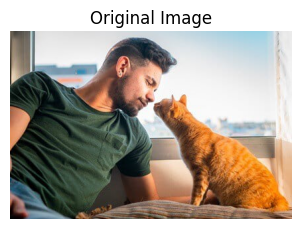

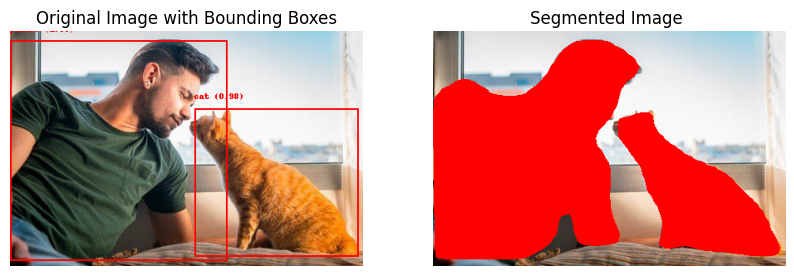

In [ ]:

# Function to calculate the area of the bounding boxes
def calculate_area(boxes):
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    return areas

# Function to process the image and get the predictions
def process_image(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)

    # Put the input image into a batch
    batch = torch.unsqueeze(image_tensor, 0)

    # Run the image through the model
    with torch.no_grad():
        prediction = model(batch)

    # Extract the boxes, labels, scores, and masks from the prediction
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    masks = prediction[0]['masks']

    # Filter predictions with confidence above the threshold
    detected_objects = []
    for i in range(boxes.shape[0]):
        if scores[i] > confidence_threshold:
            label_name = COCO_CLASS_NAMES[labels[i].item()]
            detected_objects.append((label_name, scores[i].item(), boxes[i], masks[i]))

    return detected_objects, image



# Process the image and get the predicted labels and scores
detected_objects, original_image = process_image(image_path, confidence_threshold=0.5)

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
# If objects are detected, display the segmented image with bounding boxes
if detected_objects:
    # Convert the image from PIL Image to numpy array for drawing the bounding boxes
    segmented_image = np.array(original_image.copy())

    # Create a draw object to draw on the segmented image
    draw = ImageDraw.Draw(original_image)

    for label_name, score, box, mask in detected_objects:
        # Draw bounding box on the original image
        x1, y1, x2, y2 = box.tolist()
        draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=2)

        # Apply mask to get the segmented image
        mask = mask[0].cpu().numpy()
        segmented_image[mask > 0.5] = (255, 0, 0)  # Apply red color where the mask is True

        # Draw label and confidence score on the segmented image
        label_text = f'{label_name} ({score:.2f})'
        draw.text((x1, y1 - 20), label_text, fill=(255, 0, 0), font=None)

    # Display the original image with bounding boxes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image with Bounding Boxes')
    plt.axis('off')

    # Display the segmented image with bounding boxes
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image ')
    plt.axis('off')

    plt.show()
else:
    # If no objects are detected, only display the original image
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()


